# Airline On-time Performance 2006

```bash
send for google
```

test

In [198]:
# Import libraries
# Load libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from impala.dbapi import connect
from pmdarima import auto_arima

# Set matplotlib style
plt.style.use('ggplot')

# Ignore warnings for cleaner coding
import warnings
warnings.filterwarnings('ignore')

In [199]:
# Create a connection to the Hive database using Impala
cursor = connect(
    host='127.0.0.1',
    port = 10000,
    user = 'maria_dev',
    database = 'dm_assignment2',
    auth_mechanism = 'PLAIN'
).cursor()

# Execute a query to show all tables in the database    
cursor.execute('SHOW TABLES')
print(cursor.fetchall())


[('airports',), ('carriers',), ('data',), ('plane_data',)]


In [200]:
# Wrap the data pulling process in a function for reusability
def pull_data(command):
    conn = connect(
        host='127.0.0.1',
        port=10000,
        user='maria_dev',
        database='dm_assignment2',
        auth_mechanism='PLAIN'
    )
    cursor = conn.cursor()
    cursor.execute(command)
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    df = pd.DataFrame(data, columns=columns)
    df.columns = df.columns.str.replace('^.*\.', '', regex=True)
    return df

| **Name**              | **Description**                                                             |
|-----------------------|------------------------------------------------------------------------------|
| Year                  | 1987–2008                                                                   |
| Month                 | 12–Jan                                                                      |
| DayofMonth            | 31–Jan                                                                      |
| DayOfWeek             | 1 (Monday) – 7 (Sunday)                                                     |
| DepTime               | actual departure time (local, hhmm)                                         |
| CRSDepTime            | scheduled departure time (local, hhmm)                                      |
| ArrTime               | actual arrival time (local, hhmm)                                           |
| CRSArrTime            | scheduled arrival time (local, hhmm)                                        |
| UniqueCarrier         | unique carrier code                                                         |
| FlightNum             | flight number                                                               |
| TailNum               | plane tail number                                                           |
| ActualElapsedTime     | in minutes                                                                  |
| CRSElapsedTime        | in minutes                                                                  |
| AirTime               | in minutes                                                                  |
| ArrDelay              | arrival delay, in minutes                                                   |
| DepDelay              | departure delay, in minutes                                                 |
| Origin                | origin IATA airport code                                                    |
| Dest                  | destination IATA airport code                                               |
| Distance              | in miles                                                                    |
| TaxiIn                | taxi in time, in minutes                                                    |
| TaxiOut               | taxi out time, in minutes                                                   |
| Cancelled             | was the flight cancelled?                                                   |
| CancellationCode      | reason for cancellation (A = carrier, B = weather, C = NAS, D = security)   |
| Diverted              | 1 = yes, 0 = no                                                              |
| CarrierDelay          | in minutes                                                                  |
| WeatherDelay          | in minutes                                                                  |
| NASDelay              | in minutes                                                                  |
| SecurityDelay         | in minutes                                                                  |
| LateAircraftDelay     | in minutes                                                                  |


## 1. Delay Patterns

### What times of day (morning/afternoon/evening) have the lowest average delays?

In [ ]:
query1 = '''
SELECT
  TimeOfDay,
  AVG(ArrDelay) AS AvgArrivalDelay,
  AVG(DepDelay) AS AvgDepartureDelay
FROM (
  SELECT *,
    CASE
      WHEN CRSDepTime BETWEEN 500 AND 1159 THEN 'Morning'
      WHEN CRSDepTime BETWEEN 1200 AND 1659 THEN 'Afternoon'
      WHEN CRSDepTime BETWEEN 1700 AND 2059 THEN 'Evening'
      WHEN (CRSDepTime >= 2100 AND CRSDepTime <= 2359) OR (CRSDepTime >= 0 AND CRSDepTime < 500) THEN 'Night'
      ELSE 'Unknown'
    END AS TimeOfDay
  FROM data
  WHERE Cancelled = 0
) AS categorized
GROUP BY TimeOfDay
ORDER BY AvgArrivalDelay ASC
'''

df1 = pull_data(query1)
df1

,timeofday,avgarrivaldelay,avgdeparturedelay
0,Morning,2.983879,4.492967
1,Afternoon,10.521789,11.795458
2,Night,10.923365,13.297513
3,Evening,15.818038,17.018721


In [33]:
# Sort time of day by custom order
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
df1 = df1.groupby('timeofday', observed=True).agg(
    avgarrivaldelay=('avgarrivaldelay', 'mean'),
    avgdeparturedelay=('avgdeparturedelay', 'mean')
).reindex(time_order)

df1

,avgarrivaldelay,avgdeparturedelay
timeofday,,
Morning,2.983879,4.492967
Afternoon,10.521789,11.795458
Evening,15.818038,17.018721
Night,10.923365,13.297513


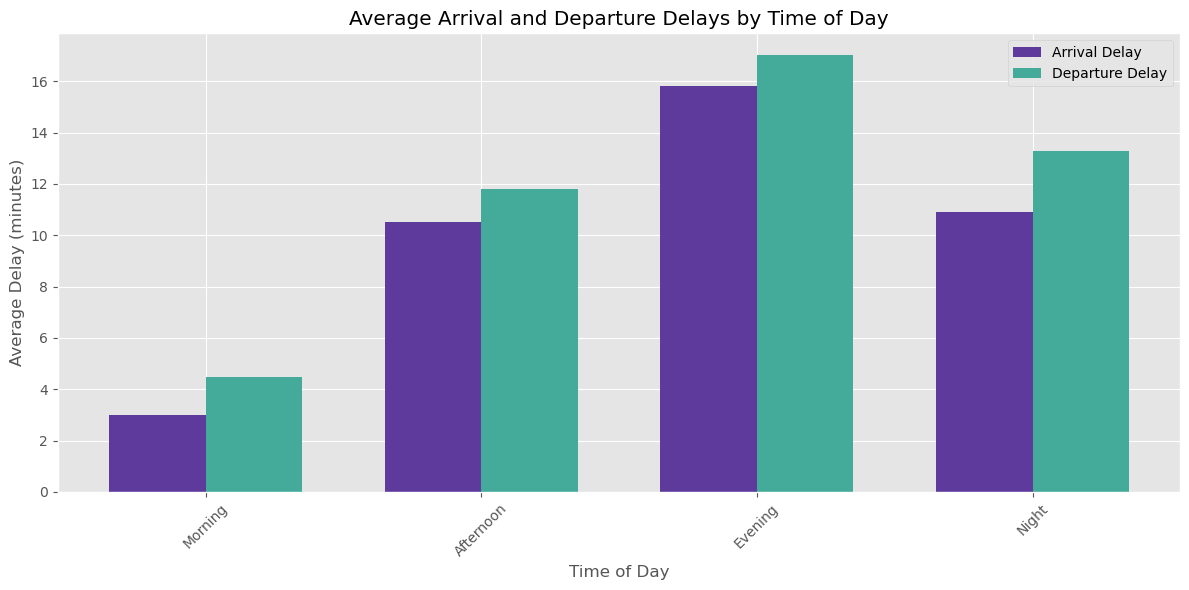

In [44]:
# Assuming df1 is your dataframe with the data
plt.figure(figsize=(12, 6))

# Set width of bars
x = np.arange(len(time_order))
width = 0.35

# Create the two bars side by side
plt.bar(x - width/2, df1['avgarrivaldelay'], width, label='Arrival Delay', color='#5D3A9B')
plt.bar(x + width/2, df1['avgdeparturedelay'], width, label='Departure Delay', color='#44AA99')

# Add labels, title and legend
plt.xlabel('Time of Day')
plt.ylabel('Average Delay (minutes)')
plt.title('Average Arrival and Departure Delays by Time of Day')
plt.xticks(x, time_order, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

### Which days of the week show better on-time performance?

In [38]:
query2 = '''
SELECT
  DayOfWeek,
  AVG(ArrDelay) AS AvgArrivalDelay,
  AVG(DepDelay) AS AvgDepartureDelay
FROM data
GROUP BY DayOfWeek
ORDER BY DayOfWeek DESC
'''

df2 = pull_data(query2)
df2

,dayofweek,avgarrivaldelay,avgdeparturedelay
0,7,8.139275,10.218353
1,6,5.169126,8.282844
2,5,12.320714,13.087679
3,4,11.575170,11.809365
4,3,7.977179,8.905728
5,2,6.195163,7.703996
6,1,8.842539,10.343310


In [40]:
# Map and sort the days of the week

df2 = df2.sort_values('dayofweek')
df2['dayofweek'] = df2['dayofweek'].map({1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'})
df2

,dayofweek,avgarrivaldelay,avgdeparturedelay
6,Monday,8.842539,10.343310
5,Tuesday,6.195163,7.703996
4,Wednesday,7.977179,8.905728
3,Thursday,11.575170,11.809365
2,Friday,12.320714,13.087679
1,Saturday,5.169126,8.282844
0,Sunday,8.139275,10.218353


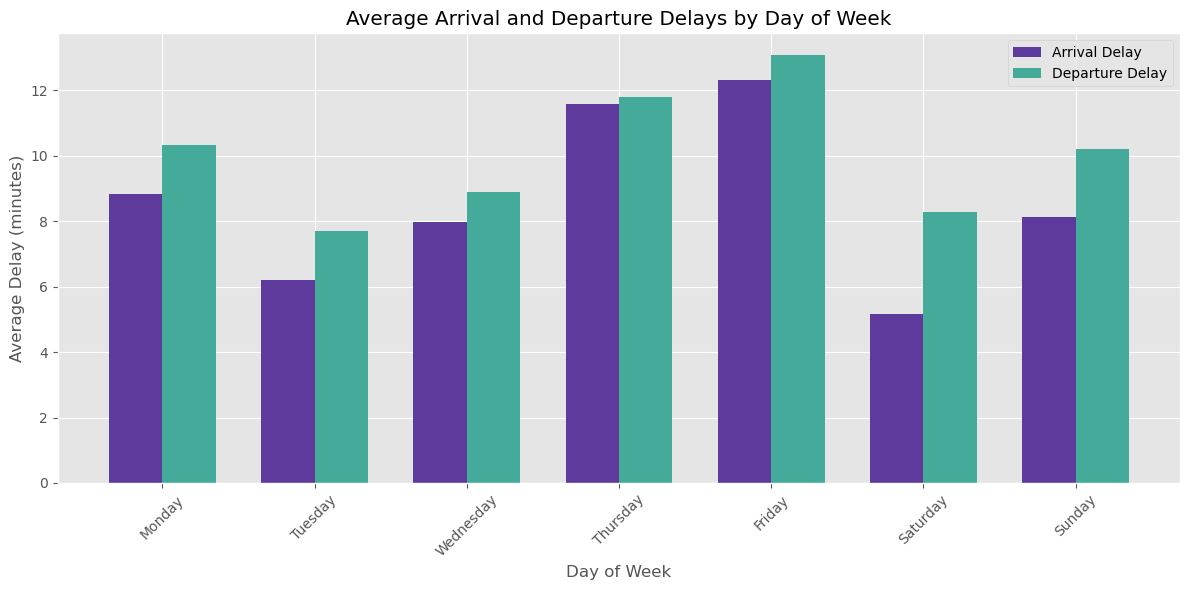

In [49]:
# Plotting the average arrival and departure delays by time of day
# Assuming df1 is your dataframe with the data
plt.figure(figsize=(12, 6))

# Set width of bars
x = np.arange(len(df2['dayofweek']))
width = 0.35

# Create the two bars side by side
plt.bar(x - width/2, df2['avgarrivaldelay'], width, label='Arrival Delay', color='#5D3A9B')
plt.bar(x + width/2, df2['avgdeparturedelay'], width, label='Departure Delay', color='#44AA99')

# Add labels, title and legend
plt.xlabel('Day of Week')
plt.ylabel('Average Delay (minutes)')
plt.title('Average Arrival and Departure Delays by Day of Week')
plt.xticks(x, df2['dayofweek'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

### During which months or seasons are flights most likely to be on time?

In [ ]:
query3 = '''
SELECT
  Month,
  CASE
    WHEN month in (12,1,2) THEN "Winter" 
    WHEN month in (3,4,5) THEN "Spring"
    WHEN month in (6,7,8) THEN "Summer"
    WHEN month in (9,10,11) THEN "Autumn"
  END AS Season,
  AVG(ArrDelay) AS AvgArrivalDelay,
  AVG(DepDelay) AS AvgDepartureDelay
FROM data
WHERE Cancelled = 0
GROUP BY Month
ORDER BY Month ASC
'''

df3 = pull_data(query3)
df3

,month,season,avgarrivaldelay,avgdeparturedelay
0,1,Winter,5.628671,8.078217
1,2,Winter,7.359394,9.142588
2,3,Spring,7.926261,9.755771
3,4,Spring,6.423710,8.194028
4,5,Spring,6.887169,8.540832
5,6,Summer,12.045558,12.933677
6,7,Summer,11.311534,12.703436
7,8,Summer,8.687387,9.936825
8,9,Autumn,8.394923,8.760106
9,10,Autumn,10.687462,10.645492


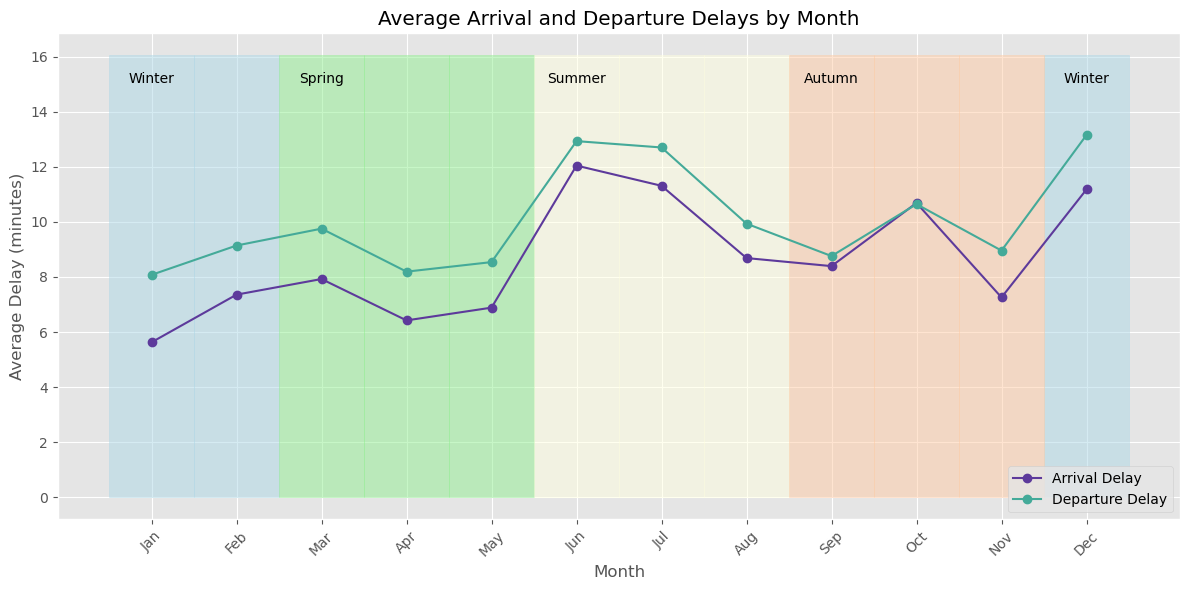

In [96]:
# Plot line chart for average arrival and departure delays by month
plt.figure(figsize=(12, 6))

plt.plot(df3['month'], df3['avgarrivaldelay'], marker='o', label='Arrival Delay', color='#5D3A9B')
plt.plot(df3['month'], df3['avgdeparturedelay'], marker='o', label='Departure Delay', color='#44AA99')

# Season colors
season_colors = {
    'Winter': '#ADD8E6',  # Light blue
    'Spring': '#90EE90',  # Light green
    'Summer': '#FFFFE0',  # Light yellow
    'Autumn': '#FFCBA4'     # Light orange/peach
}

# Create a list to store legend elements
legend_elements = []

# Get the maximum y-value for the fill (slightly above the max delay)
max_y = df3['avgarrivaldelay'].max() + 4

# Add seasonal shading with improved approach to avoid gaps
for season in df3['season'].unique():
    # Extract month values where season matches
    season_data = df3[df3['season'] == season]
    
    # Create extended x values for each month to create blocks
    for _, row in season_data.iterrows():
        month = row['month']
        # Create rectangular blocks by extending 0.5 in both directions
        x_rect = [month - 0.5, month + 0.5, month + 0.5, month - 0.5]
        y_rect = [0, 0, max_y, max_y]
        
        plt.fill(x_rect, y_rect, color=season_colors[season], alpha=0.5, zorder=1)
    
    # Add to legend elements (only once per season)
    from matplotlib.patches import Patch
    legend_elements.append(Patch(facecolor=season_colors[season], alpha=0.5, label=season))

# Add lines to legend elements
line_elements = plt.gca().get_legend_handles_labels()[0]
legend_elements = line_elements + legend_elements

plt.text(1, max_y-1, 'Winter', fontsize=10, color='black', ha='center')
plt.text(3, max_y-1, 'Spring', fontsize=10, color='black', ha='center')
plt.text(6, max_y-1, 'Summer', fontsize=10, color='black', ha='center')
plt.text(9, max_y-1, 'Autumn', fontsize=10, color='black', ha='center')
plt.text(12, max_y-1, 'Winter', fontsize=10, color='black', ha='center')

plt.xlabel('Month')
plt.ylabel('Average Delay (minutes)')
plt.title('Average Arrival and Departure Delays by Month')
plt.xticks(df3['month'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


## 2. Delay Factors

### Identify and rank the top 3-5 factors contributing to flight delays, based on the delay categories provided in the dataset.

In [133]:
query4 = '''
SELECT
  DelayType,
  AvgDelayMinutes,
  IncidentCount
FROM (
  SELECT 'CarrierDelay' AS DelayType,
         AVG(CarrierDelay) AS AvgDelayMinutes,
         SUM(CASE WHEN CarrierDelay > 0 THEN 1 ELSE 0 END) AS IncidentCount
  FROM data
  WHERE CarrierDelay > 0

  UNION ALL

  SELECT 'WeatherDelay',
         AVG(WeatherDelay),
         SUM(CASE WHEN WeatherDelay > 0 THEN 1 ELSE 0 END)
  FROM data
  WHERE WeatherDelay > 0

  UNION ALL

  SELECT 'NASDelay',
         AVG(NASDelay),
         SUM(CASE WHEN NASDelay > 0 THEN 1 ELSE 0 END)
  FROM data
  WHERE NASDelay > 0

  UNION ALL

  SELECT 'SecurityDelay',
         AVG(SecurityDelay),
         SUM(CASE WHEN SecurityDelay > 0 THEN 1 ELSE 0 END)
  FROM data
  WHERE SecurityDelay > 0

  UNION ALL

  SELECT 'LateAircraftDelay',
         AVG(LateAircraftDelay),
         SUM(CASE WHEN LateAircraftDelay > 0 THEN 1 ELSE 0 END)
  FROM data
  WHERE LateAircraftDelay > 0
) AS DelaySummary
ORDER BY AvgDelayMinutes DESC
LIMIT 5
'''
df4 = pull_data(query4)
df4

,delaytype,avgdelayminutes,incidentcount
0,LateAircraftDelay,44.092380,731324
1,WeatherDelay,42.673773,113743
2,CarrierDelay,33.765334,718349
3,NASDelay,27.191464,941866
4,SecurityDelay,20.741216,10673


In [134]:
df4['incident_percent'] = df4['incidentcount'] / df4['incidentcount'].sum() * 100
df4['incident_percent'] = df4['incident_percent'].round(2)

df4

,delaytype,avgdelayminutes,incidentcount,incident_percent
0,LateAircraftDelay,44.092380,731324,29.07
1,WeatherDelay,42.673773,113743,4.52
2,CarrierDelay,33.765334,718349,28.55
3,NASDelay,27.191464,941866,37.44
4,SecurityDelay,20.741216,10673,0.42


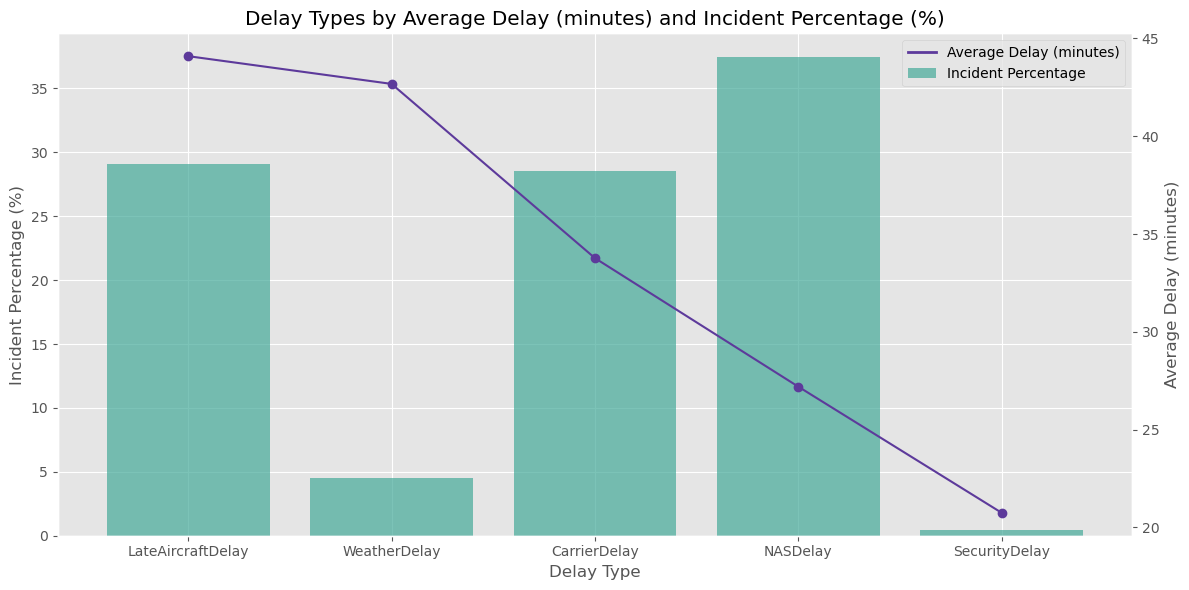

In [139]:
# Plot delaytype vs delaymins and incident percentage on second axis
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(df4['delaytype'], df4['incident_percent'], color='#44AA99', alpha=0.7, label='Incident Percentage')
ax1.set_xlabel('Delay Type')
ax1.set_ylabel('Incident Percentage (%)')
ax1.set_title('Delay Types by Average Delay (minutes) and Incident Percentage (%)')

# Create a second y-axis for the incident percentage
ax2 = ax1.twinx()
ax2.plot(df4['delaytype'], df4['avgdelayminutes'], color='#5D3A9B', marker='o', label='Average Delay (minutes)')
ax2.set_ylabel('Average Delay (minutes)')

# Create a custom legend for both
legend_elements = [
    plt.Line2D([0], [0], color='#5D3A9B', lw=2, label='Average Delay (minutes)'),
    Patch(facecolor='#44AA99', alpha=0.7, label='Incident Percentage')
]

plt.legend(handles=legend_elements)
plt.grid()
plt.tight_layout()
plt.show()

### Quantify the impact of each factor (in minutes of delay and percentage of total delays).

## 3. Cancellation Analysis

### Identify the primary reasons for flight cancellations as categorized in the dataset.

In [125]:
query5 = '''
SELECT
	CASE
		WHEN CancellationCode = "A" THEN "Carrier"
		WHEN CancellationCode = "B" THEN "Weather"
		WHEN CancellationCode = "C" THEN "NAS"
		WHEN CancellationCode = "D" THEN "Security"
	END as cancellation_code,
	SUM(Cancelled) as count_cancellation
FROM data
WHERE Cancelled = 1
GROUP BY CancellationCode
ORDER BY count_cancellation DESC
'''

df5 = pull_data(query5)
df5

,cancellation_code,count_cancellation
0,Carrier,55655
1,Weather,37913
2,NAS,28209
3,Security,157


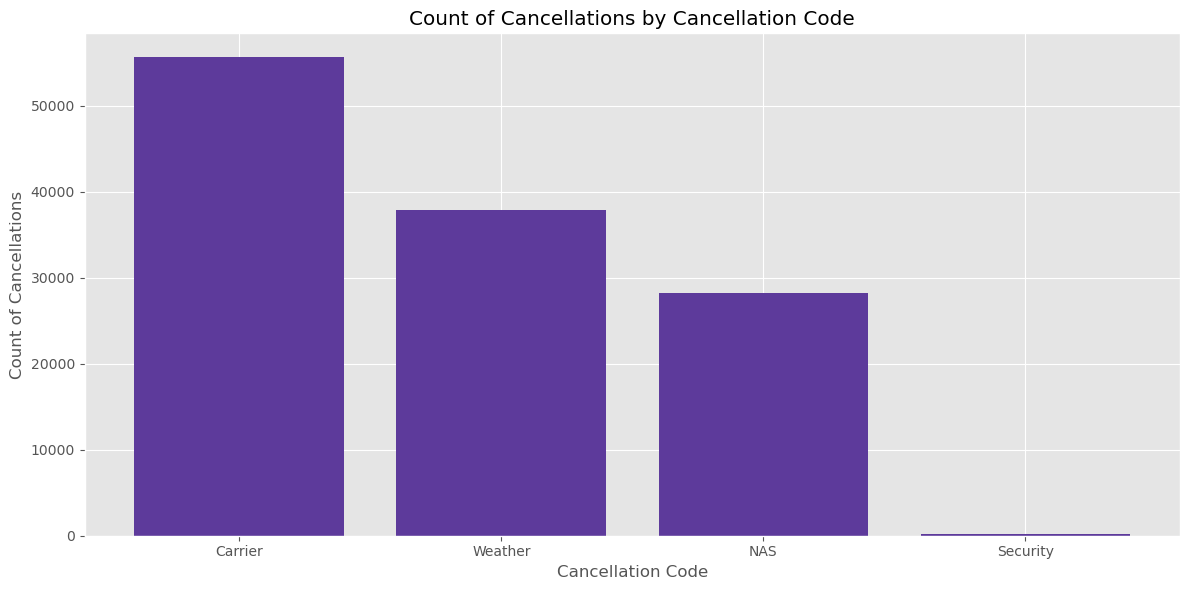

In [127]:
# Plot the count of cancellations by cancellation code
plt.figure(figsize=(12, 6))
plt.bar(df5['cancellation_code'], df5['count_cancellation'], color='#5D3A9B')
plt.xlabel('Cancellation Code')
plt.ylabel('Count of Cancellations')
plt.title('Count of Cancellations by Cancellation Code')
plt.tight_layout()
plt.show()

### Determine if cancellations correlate with specific airlines, airports, or time periods.

#### Airline

In [201]:
query7 = '''
SELECT * 
FROM (
    SELECT 
        d.UniqueCarrier AS CarrierCode,
        c.Description AS Description,
        SUM(CASE WHEN d.Cancelled > 0 THEN 1 ELSE 0 END) AS cancellation_count, 
        COUNT(*) AS total_flights,
        ROUND(100.0 * SUM(CASE WHEN d.Cancelled > 0 THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancellation_rate_pct
    FROM 
        data d
    LEFT JOIN 
        carriers c ON d.UniqueCarrier = c.Code
    GROUP BY 
        d.UniqueCarrier, c.Description
) sub
ORDER BY 
    cancellation_rate_pct DESC
'''

df7 = pull_data(query7)
df7

,carriercode,description,cancellation_count,total_flights,cancellation_rate_pct
0,MQ,American Eagle Airlines Inc.,19990,550088,3.63
1,YV,Mesa Airlines Inc.,9544,304764,3.13
2,EV,Atlantic Southeast Airlines,6783,273143,2.48
3,OH,Comair Inc.,6875,278099,2.47
4,OO,Skywest Airlines Inc.,12844,548109,2.34
5,XE,Expressjet Airlines Inc.,9716,441470,2.20
6,AQ,Aloha Airlines Inc.,745,35387,2.11
7,UA,United Air Lines Inc.,10238,500008,2.05
8,AA,American Airlines Inc.,10127,643597,1.57
9,DL,Delta Air Lines Inc.,7695,506086,1.52


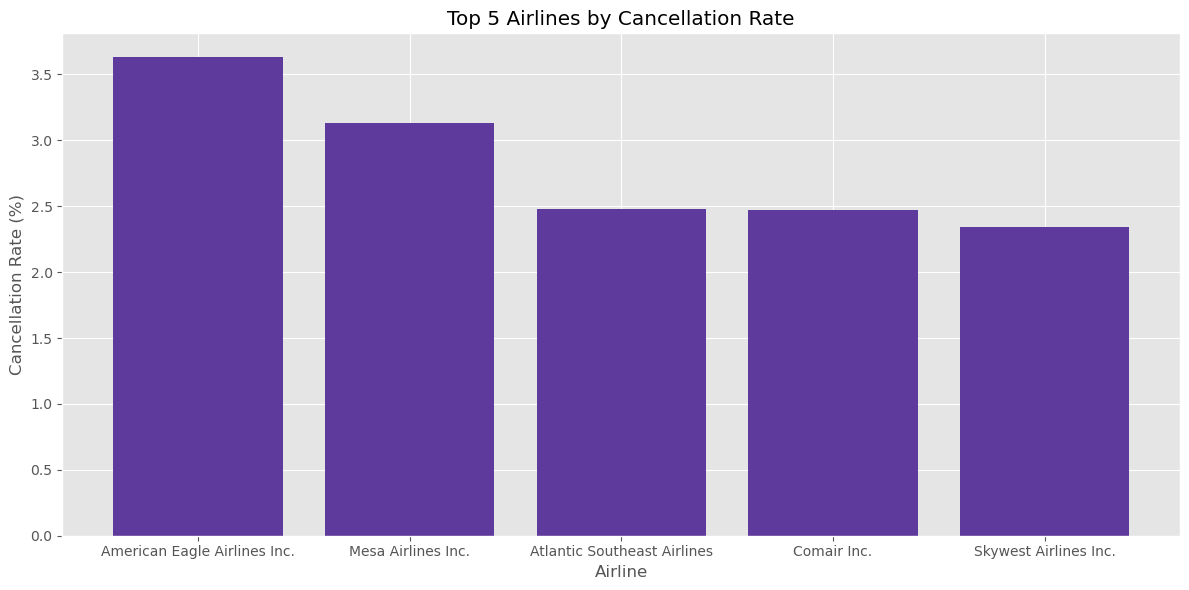

In [202]:
# Plot top 5 carriers by cancellation rate
top5_airline_cancellation = df7.head(5)
plt.figure(figsize=(12, 6))
plt.bar(top5_airline_cancellation['description'], top5_airline_cancellation['cancellation_rate_pct'], color='#5D3A9B')
plt.xlabel('Airline')
plt.ylabel('Cancellation Rate (%)')
plt.title('Top 5 Airlines by Cancellation Rate')
plt.tight_layout()
plt.show()

#### Airport

In [149]:
query6 = '''
WITH airport_stats AS (
    SELECT COALESCE(o.Origin, d.Dest) AS AirportCode, 
           o.cancellation_count AS Origin_Cancellation_count, 
           o.total_flights AS Origin_Total_Flights, 
           CASE WHEN o.total_flights > 0 THEN (o.cancellation_count * 100.0 / o.total_flights) ELSE 0 END AS Origin_Cancellation_Rate, 
           d.cancellation_count AS Dest_Cancellation_count, 
           d.total_flights AS Dest_Total_Flights, 
           CASE WHEN d.total_flights > 0 THEN (d.cancellation_count * 100.0 / d.total_flights) ELSE 0 END AS Dest_Cancellation_Rate
    FROM (
        SELECT Origin, 
               SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) AS cancellation_count, 
               COUNT(*) AS total_flights 
        FROM data 
        GROUP BY Origin
    ) o 
    FULL OUTER JOIN (
        SELECT Dest, 
               SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) AS cancellation_count, 
               COUNT(*) AS total_flights 
        FROM data 
        GROUP BY Dest
    ) d ON o.Origin = d.Dest
)

SELECT 
    a.AirportCode,
    ap.airport AS AirportName,
    ap.city AS City,
    ap.state AS State,
    ap.country AS Country,
    ap.lat AS Latitude,
    ap.long AS Longitude,
    a.Origin_Cancellation_count,
    a.Origin_Total_Flights,
    a.Origin_Cancellation_Rate,
    a.Dest_Cancellation_count,
    a.Dest_Total_Flights,
    a.Dest_Cancellation_Rate
FROM 
    airport_stats a
LEFT JOIN 
    airports ap ON a.AirportCode = ap.iata
ORDER BY 
    a.Origin_Cancellation_Rate DESC, 
    a.Dest_Cancellation_Rate DESC
'''

df6 = pull_data(query6)
df6.head()

,airportcode,airportname,city,state,country,latitude,longitude,origin_cancellation_count,origin_total_flights,origin_cancellation_rate,dest_cancellation_count,dest_total_flights,dest_cancellation_rate
0,TEX,Telluride Regional,Telluride,CO,USA,37.953759,-107.908480,33.0,273.0,12.087912,15.0,273.0,5.494505
1,HKY,Hickory Municipal,Hickory,NC,USA,35.741146,-81.389549,5.0,42.0,11.904762,5.0,41.0,12.195122
2,ACK,Nantucket Memorial,Nantucket,MA,USA,41.253052,-70.060181,26.0,235.0,11.063830,27.0,235.0,11.489362
3,ADK,Adak,Adak,AK,USA,51.877964,-176.646031,11.0,104.0,10.576923,11.0,104.0,10.576923
4,ASE,Aspen-Pitkin Co/Sardy,Aspen,CO,USA,39.223160,-106.868845,294.0,3733.0,7.875703,270.0,3716.0,7.265877


##### Origin Cancellation Rate

In [186]:
# Sort and select top 5 airports by origin cancellation rate
top5 = df6.sort_values(by='origin_cancellation_rate', ascending=False).head(5)
top5_codes = top5['airportname'].tolist()
top5_codes


['Telluride Regional',
 'Hickory Municipal',
 'Nantucket Memorial',
 'Adak',
 'Aspen-Pitkin Co/Sardy ']

In [187]:
# Add a new column indicating if the airport is in top 5
df6['Group_'] = df6['airportname'].apply(lambda x: 'Top 5' if x in top5_codes else 'Others')

# Drop missing cancellation rates
df_clean = df6.dropna(subset=['origin_cancellation_rate', 'dest_cancellation_rate'])


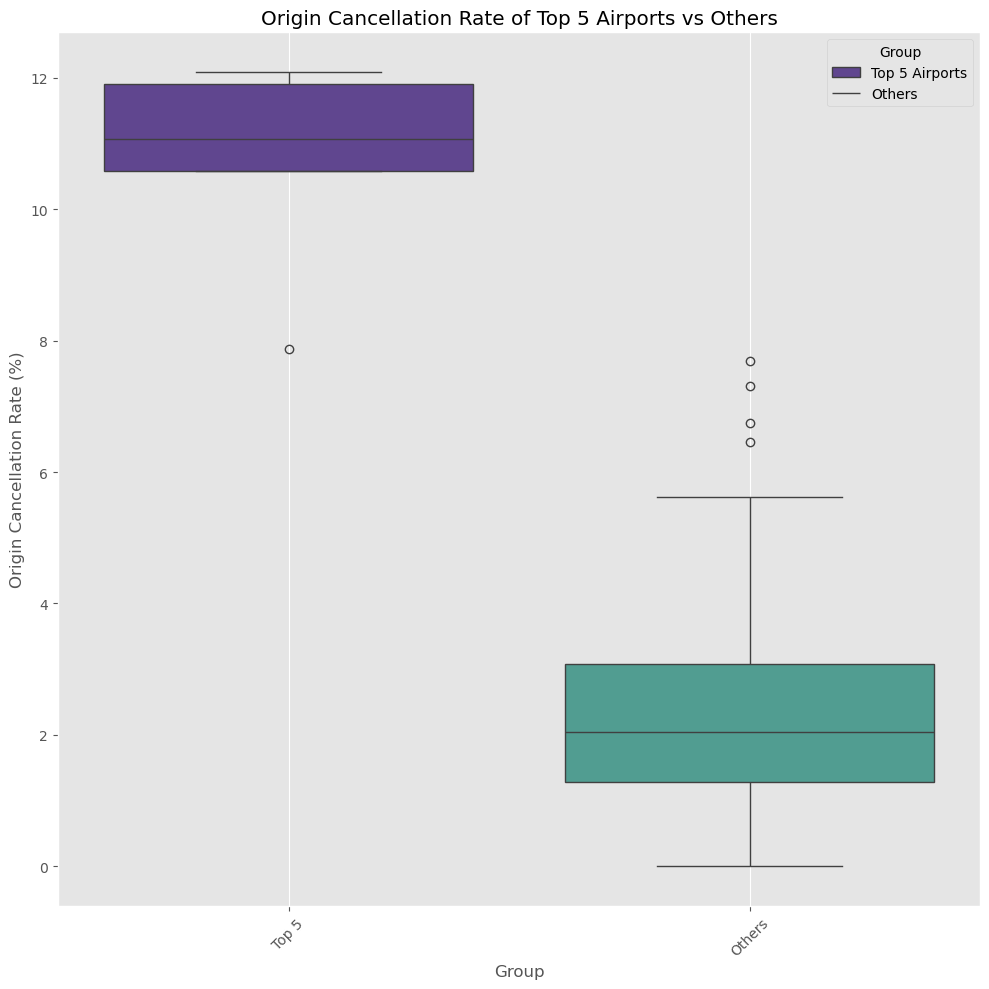

In [193]:
# Plot the cancellation rate of top 5 airports vs others
plt.figure(figsize=(10, 10))
sns.boxplot(x='Group_', y='origin_cancellation_rate', data=df_clean, palette=['#5D3A9B', '#44AA99'])
plt.title('Origin Cancellation Rate of Top 5 Airports vs Others')
plt.xlabel('Group')
plt.ylabel('Origin Cancellation Rate (%)')
plt.xticks(rotation=45)
plt.legend(title='Group', loc='upper right', labels=['Top 5 Airports', 'Others'])
plt.grid()
plt.tight_layout()
plt.show()

In [188]:
from scipy.stats import ttest_ind

top5_rates = df_clean[df_clean['Group'] == 'Top 5']['origin_cancellation_rate']
others_rates = df_clean[df_clean['Group'] == 'Others']['origin_cancellation_rate']

t_stat, p_val = ttest_ind(top5_rates, others_rates, equal_var=False)

print(f"Welch's t-test: t = {t_stat:.4f}, p = {p_val:.4f}")


Welch's t-test: t = 8.1521, p = 0.0011


##### Destination Cancellation Rate

In [194]:
# Sort and select top 5 airports by origin cancellation rate
top5 = df6.sort_values(by='dest_cancellation_rate', ascending=False).head(5)
top5_codes = top5['airportname'].tolist()
top5_codes


['Hickory Municipal',
 'Nantucket Memorial',
 'Adak',
 'Kodiak ',
 'Aspen-Pitkin Co/Sardy ']

In [195]:
# Add a new column indicating if the airport is in top 5
df6['Group'] = df6['airportname'].apply(lambda x: 'Top 5' if x in top5_codes else 'Others')

# Drop missing cancellation rates
df_clean = df6.dropna(subset=['origin_cancellation_rate', 'dest_cancellation_rate'])


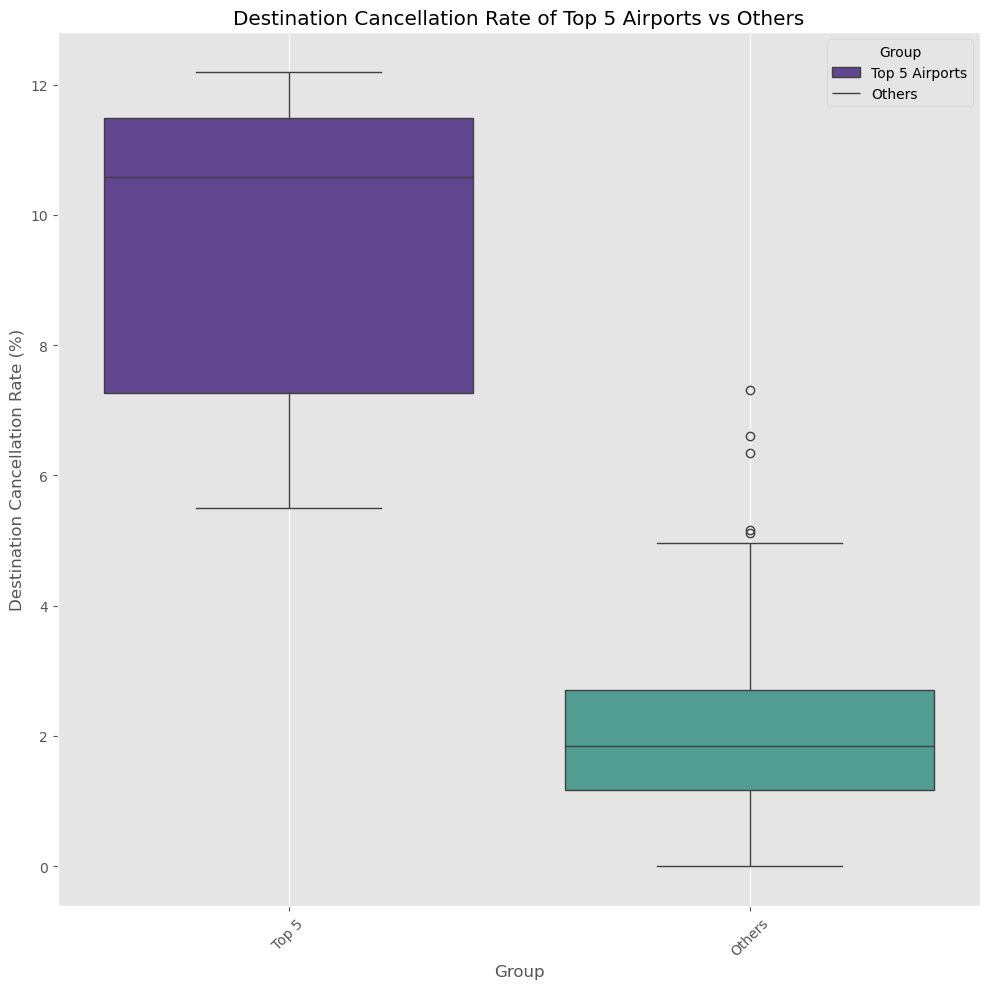

In [197]:
# Plot the cancellation rate of top 5 airports vs others
plt.figure(figsize=(10, 10))
sns.boxplot(x='Group_', y='dest_cancellation_rate', data=df_clean, palette=['#5D3A9B', '#44AA99'])
plt.title('Destination Cancellation Rate of Top 5 Airports vs Others')
plt.xlabel('Group')
plt.ylabel('Destination Cancellation Rate (%)')
plt.xticks(rotation=45)
plt.legend(title='Group', loc='upper right', labels=['Top 5 Airports', 'Others'])
plt.grid()
plt.tight_layout()
plt.show()

In [196]:
from scipy.stats import ttest_ind

top5_rates = df_clean[df_clean['Group'] == 'Top 5']['dest_cancellation_rate']
others_rates = df_clean[df_clean['Group'] == 'Others']['dest_cancellation_rate']

t_stat, p_val = ttest_ind(top5_rates, others_rates, equal_var=False)

print(f"Welch's t-test: t = {t_stat:.4f}, p = {p_val:.4f}")


Welch's t-test: t = 7.3900, p = 0.0017


##### Combined Plot

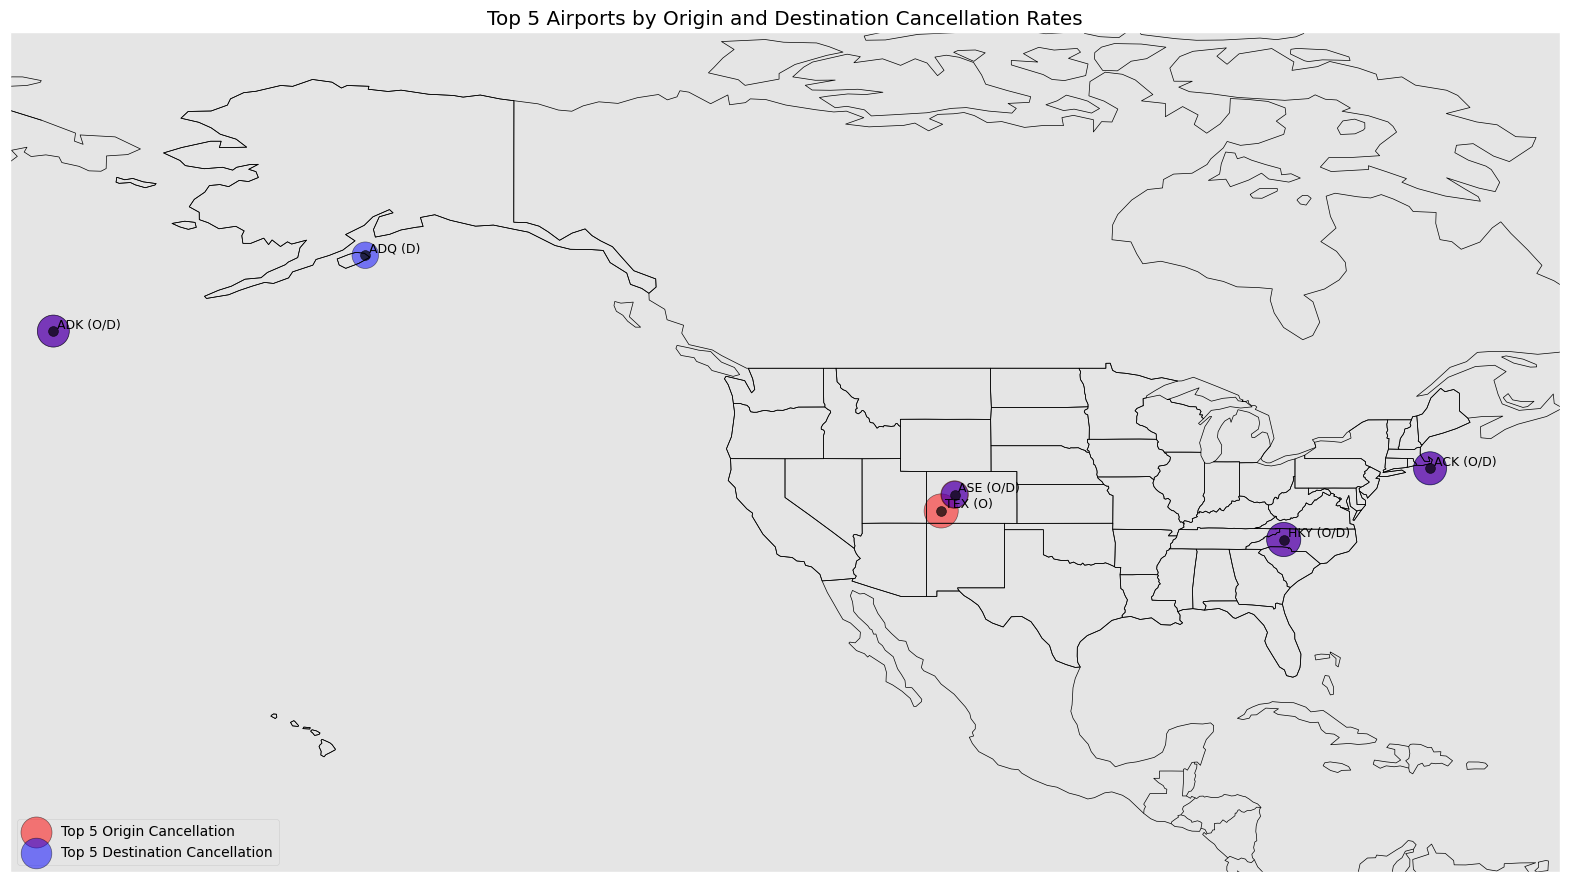

In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load your dataframe or use your existing one
# df = pd.read_csv('your_data.csv')

# Select top 5 by origin and destination cancellation rate
top5_origin = df6.sort_values(by='origin_cancellation_rate', ascending=False).head(5)
top5_dest = df6.sort_values(by='dest_cancellation_rate', ascending=False).head(5)

# Set up the map
plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())

# Map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.set_extent([-180, -60, 10, 75], crs=ccrs.PlateCarree())


# Plot top 5 origin cancellation airports
origin_scatter = ax.scatter(
    top5_origin['longitude'],
    top5_origin['latitude'],
    s=top5_origin['origin_cancellation_rate'] * 50,
    color='red',
    alpha=0.5,
    label='Top 5 Origin Cancellation',
    edgecolor='k',
    transform=ccrs.PlateCarree()
)

# Plot top 5 destination cancellation airports
dest_scatter = ax.scatter(
    top5_dest['longitude'],
    top5_dest['latitude'],
    s=top5_dest['dest_cancellation_rate'] * 50,
    color='blue',
    alpha=0.5,
    label='Top 5 Destination Cancellation',
    edgecolor='k',
    transform=ccrs.PlateCarree()
)

# Add airport names to the scatter points
# If origin and destination airports have the same name, use 1 label
# Combine top5 origin and destination airports
combined = pd.concat([top5_origin, top5_dest]).drop_duplicates(subset='airportcode')

# Add a column indicating label type: O, D, or both
def get_label_type(row):
    is_origin = row['airportcode'] in top5_origin['airportcode'].values
    is_dest = row['airportcode'] in top5_dest['airportcode'].values
    if is_origin and is_dest:
        return '(O/D)'
    elif is_origin:
        return '(O)'
    elif is_dest:
        return '(D)'

combined['label'] = combined.apply(get_label_type, axis=1)

# Plot all combined airports with appropriate colors and labels
for _, row in combined.iterrows():
    color = 'black'
    ax.scatter(row['longitude'], row['latitude'],
               s=50,
               color=color,
               alpha=0.7,
               edgecolor='k',
               transform=ccrs.PlateCarree())

    ax.text(row['longitude'] + 0.3, row['latitude'] + 0.3,
            f"{row['airportcode']} {row['label']}",
            fontsize=9,
            color=color,
            transform=ccrs.PlateCarree())

# Final touches
plt.title('Top 5 Airports by Origin and Destination Cancellation Rates')
plt.legend(loc='lower left')
plt.show()


#### Time-period

##### Month

In [222]:
query8 = '''
SELECT
	Month,
	SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) AS cancellation_count, 
	COUNT(*) AS total_flights,
    ROUND(100.0 * SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancellation_rate_pct
FROM data
GROUP BY Month
ORDER BY Month ASC
'''

df8 = pull_data(query8)
df8

,month,cancellation_count,total_flights,cancellation_rate_pct
0,1,9787,581287,1.68
1,2,11293,531247,2.13
2,3,7586,605217,1.25
3,4,6604,585351,1.13
4,5,7057,602919,1.17
5,6,10088,598315,1.69
6,7,10735,621244,1.73
7,8,9783,628732,1.56
8,9,9950,584937,1.70
9,10,11399,611718,1.86


In [245]:
query9 = '''
SELECT
    Month,
    CASE
        WHEN DayOfWeek = 1 THEN 'Mon'
        WHEN DayOfWeek = 2 THEN 'Tue'
        WHEN DayOfWeek = 3 THEN 'Wed'
        WHEN DayOfWeek = 4 THEN 'Thu'
        WHEN DayOfWeek = 5 THEN 'Fri'
        WHEN DayOfWeek = 6 THEN 'Sat'
        WHEN DayOfWeek = 7 THEN 'Sun'
    END AS DayOfWeek,
    SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) AS cancellation_count,
    COUNT(*) AS total_flights
FROM data
GROUP BY Month, DayOfWeek
'''
df9 = pull_data(query9)
df9

,month,dayofweek,cancellation_count,total_flights
0,7,Thu,2442,83096
1,8,Sat,566,73418
2,9,Tue,1381,79635
3,9,Wed,1139,79351
4,12,Wed,2475,81240
...,...,...,...,...
79,4,Tue,817,78945
80,7,Sat,879,91688
81,9,Thu,1089,81896
82,9,Sun,1136,74942


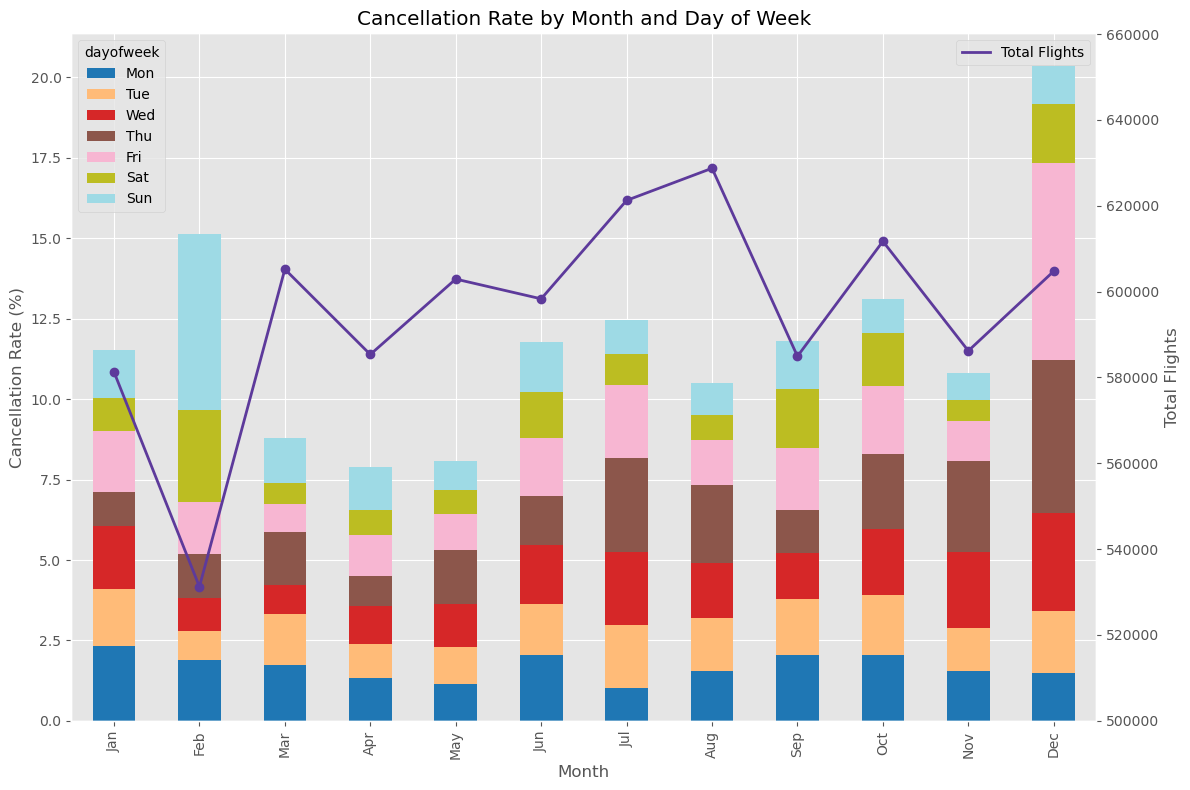

In [277]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create pivot table for cancellation rate by month and day of week
df9['cancel_rate'] = df9['cancellation_count'] / df9['total_flights'] * 100
pivot_df = df9.pivot_table(index='month', columns='dayofweek', values='cancel_rate', fill_value=0)
pivot_df = pivot_df[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']]

# Ensure the index is 1-12 for months
pivot_df.index = list(range(1, 13))

# Define month labels
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot Stacked bar chart
bars = pivot_df.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20', ax=ax1)
ax1.set_xlabel('Month')
ax1.set_ylabel('Cancellation Rate (%)')
ax1.set_title('Cancellation Rate by Month and Day of Week')

# Create a second y-axis for total flights
ax2 = ax1.twinx()

# This is the key fix: We need to use the x-positions of the bars for the line plot
x_positions = np.arange(len(pivot_df.index))  # Get bar positions (0-11)

# Ensure df8 is properly aligned with the same months (1-12)
# Match df8's data to the bar positions
total_flights_data = []
for month in range(1, 13):
    if month in df8['month'].values:
        total_flights_data.append(df8.loc[df8['month'] == month, 'total_flights'].values[0])
    else:
        total_flights_data.append(0)  # Or handle missing months appropriately

# Plot the line using the bar positions
ax2.plot(x_positions, total_flights_data, color='#5D3A9B', marker='o', label='Total Flights', linewidth=2)
ax2.set_ylim(500000, max(total_flights_data) * 1.05)
ax2.set_ylabel('Total Flights')

# Create combined legend
legend_elements = [plt.Line2D([0], [0], color='#5D3A9B', lw=2, label='Total Flights')]
ax2.legend(handles=legend_elements, loc='upper right')

# Set x-tick labels to month names
ax1.set_xticks(x_positions)
ax1.set_xticklabels(month_labels)

plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [284]:
query10 = '''
SELECT
    DayofMonth,
    CASE
        WHEN DayOfWeek = 1 THEN 'Mon'
        WHEN DayOfWeek = 2 THEN 'Tue'
        WHEN DayOfWeek = 3 THEN 'Wed'
        WHEN DayOfWeek = 4 THEN 'Thu'
        WHEN DayOfWeek = 5 THEN 'Fri'
        WHEN DayOfWeek = 6 THEN 'Sat'
        WHEN DayOfWeek = 7 THEN 'Sun'
    END AS DayOfWeek,
	SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) AS cancellation_count, 
	COUNT(*) AS total_flights,
    ROUND(100.0 * SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancellation_rate_pct
FROM data
WHERE Month = 4
GROUP BY DayofMonth, DayOfWeek
ORDER BY DayofMonth, DayOfWeek ASC
'''
df10 = pull_data(query10)
df10

,dayofmonth,dayofweek,cancellation_count,total_flights,cancellation_rate_pct
0,1,Sat,149,17207,0.87
1,2,Sun,328,19214,1.71
2,3,Mon,527,20264,2.60
3,4,Tue,357,19693,1.81
4,5,Wed,276,20087,1.37
5,6,Thu,210,20325,1.03
6,7,Fri,366,20349,1.80
7,8,Sat,159,17338,0.92
8,9,Sun,106,19307,0.55
9,10,Mon,127,20285,0.63


##### Day

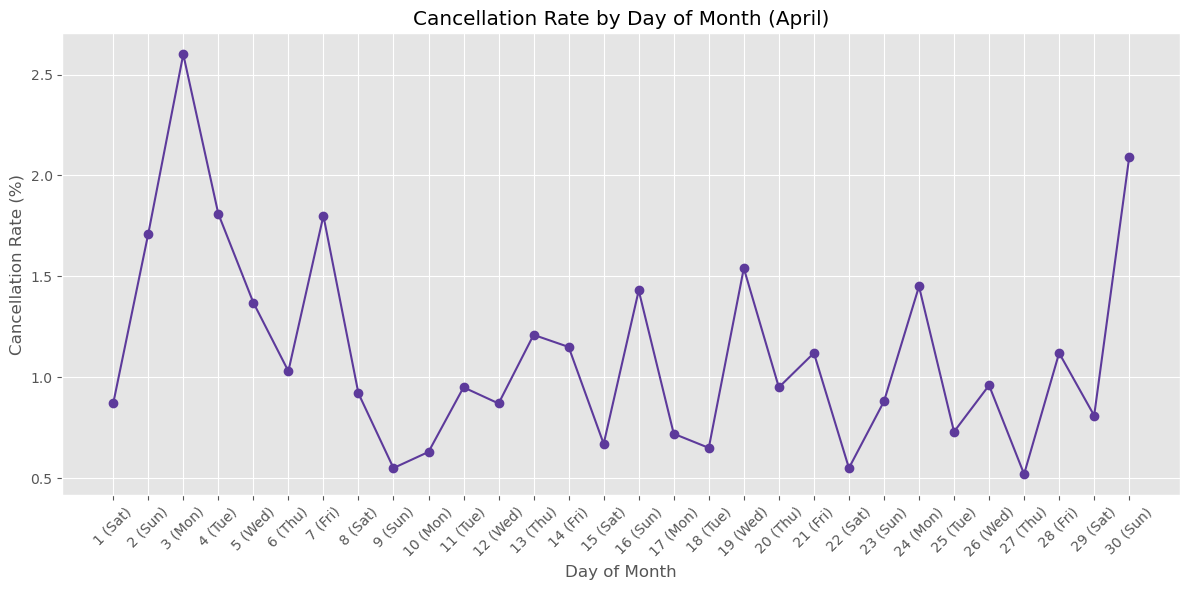

In [309]:
# Plot the day of month vs cancellation rate
plt.figure(figsize=(12, 6))
plt.plot(df10['dayofmonth'], df10['cancellation_rate_pct'], marker='o', color='#5D3A9B')


# Get the x-positions (days of month)
x_positions = df10['dayofmonth']


day_labels = df10['dayofweek']

# Get the corresponding day of week labels
for index, label in zip(x_positions, df10['dayofweek']):
    day_labels[index-1] = f"{index} ({label})"

plt.xlabel('Day of Month')
plt.ylabel('Cancellation Rate (%)')
plt.title('Cancellation Rate by Day of Month (April)')
plt.xticks(ticks=x_positions, labels=day_labels, rotation=45)
plt.tight_layout()
plt.show()

##### Time

In [296]:
# April, Thursday
query11 = '''
SELECT
  CASE
    WHEN CRSDepTime BETWEEN 500 AND 1159 THEN 'Morning'
    WHEN CRSDepTime BETWEEN 1200 AND 1659 THEN 'Afternoon'
    WHEN CRSDepTime BETWEEN 1700 AND 2059 THEN 'Evening'
    WHEN (CRSDepTime >= 2100 AND CRSDepTime <= 2359) OR (CRSDepTime >= 0 AND CRSDepTime < 500) THEN 'Night'
    ELSE 'Unknown'
  END AS crsdeptime,
  SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) AS cancellation_count, 
  COUNT(*) AS total_flights,
  ROUND(100.0 * SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancellation_rate_pct
FROM data
WHERE
  Month = 4 AND DayOfWeek = 4
GROUP BY
  CASE
    WHEN CRSDepTime BETWEEN 500 AND 1159 THEN 'Morning'
    WHEN CRSDepTime BETWEEN 1200 AND 1659 THEN 'Afternoon'
    WHEN CRSDepTime BETWEEN 1700 AND 2059 THEN 'Evening'
    WHEN (CRSDepTime >= 2100 AND CRSDepTime <= 2359) OR (CRSDepTime >= 0 AND CRSDepTime < 500) THEN 'Night'
    ELSE 'Unknown'
  END
ORDER BY crsdeptime
'''

df11 = pull_data(query11)
df11

,crsdeptime,cancellation_count,total_flights,cancellation_rate_pct
0,Afternoon,249,25375,0.98
1,Evening,189,18647,1.01
2,Morning,280,32934,0.85
3,Night,34,4186,0.81


In [ ]:
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
df11 = df11.groupby('crsdeptime', observed=True).agg(
    cancellation_count=('cancellation_count', 'mean'),
    total_flights=('total_flights', 'mean'),
    cancellation_rate_pct=('cancellation_rate_pct', 'mean')
).reindex(time_order)

In [302]:
df11

,cancellation_count,total_flights,cancellation_rate_pct
crsdeptime,,,
Morning,280.0,32934.0,0.85
Afternoon,249.0,25375.0,0.98
Evening,189.0,18647.0,1.01
Night,34.0,4186.0,0.81


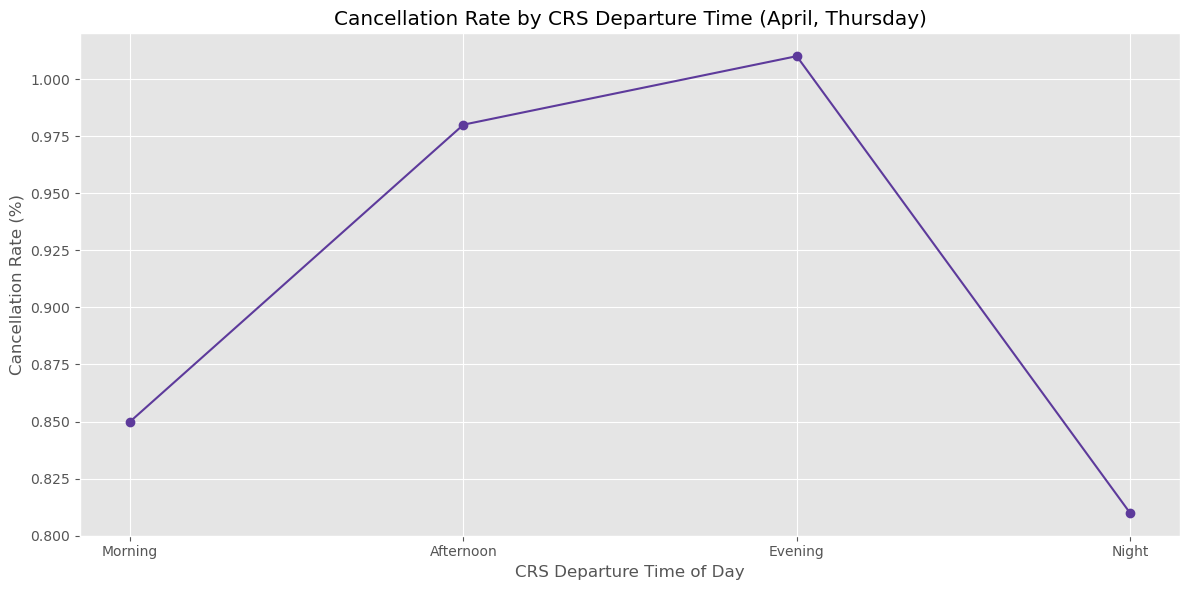

In [305]:
# Plot the crsdep time vs cancellation rate
plt.figure(figsize=(12, 6))
plt.plot(df11.index, df11['cancellation_rate_pct'], marker='o', color='#5D3A9B')

plt.xlabel('CRS Departure Time of Day')
plt.ylabel('Cancellation Rate (%)')
plt.title('Cancellation Rate by CRS Departure Time (April, Thursday)')
plt.tight_layout()
plt.show()

## 4. Problematic Routes

### Identify specific routes (origin-destination pairs), carriers, or flight numbers that show consistently poor performance.

In [306]:
query12 = '''
SELECT
    Origin,
    Dest,
    COUNT(*) AS total_flights,
    SUM(CASE WHEN Cancelled = 1 THEN 1 ELSE 0 END) AS cancellation_count,
    ROUND(100.0 * SUM(CASE WHEN Cancelled = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancel_rate_pct,
    AVG(ArrDelay) AS avg_arrival_delay,
    AVG(DepDelay) AS avg_departure_delay
FROM data
GROUP BY Origin, Dest
HAVING COUNT(*) >= 100 -- filter out low-volume routes
ORDER BY cancel_rate_pct DESC, avg_arrival_delay DESC
LIMIT 20
'''
df12 = pull_data(query12)
df12

,origin,dest,total_flights,cancellation_count,cancel_rate_pct,avg_arrival_delay,avg_departure_delay
0,PHL,EWR,151,27,17.88,18.104839,12.798387
1,EWR,PHL,151,27,17.88,12.870968,10.927419
2,LGA,LEX,328,40,12.20,20.310954,21.322917
3,TEX,PHX,273,33,12.09,8.020833,6.916667
4,EWR,ACK,235,27,11.49,31.321951,30.500000
5,ACK,EWR,235,26,11.06,38.878049,33.511962
6,LGA,TYS,316,32,10.13,28.609155,22.207746
7,ADK,AKN,103,10,9.71,32.987805,39.000000
8,AKN,ADK,103,10,9.71,14.322581,16.354839
9,ASE,PHX,313,29,9.27,16.551601,18.126761


### Analyse the reasons these particular flights are prone to delays or cancellations.